# Load libraries and set device up

In [1]:
import matplotlib.pyplot as plt
import numpy             as np
import seaborn           as sns
import torch.nn          as nn
import os
import torch
import json

import libraries.model   as clm
import libraries.dataset as cld

from torch_geometric.loader import DataLoader

# Checking if pytorch can run in GPU, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sns.set_theme()

In [2]:
target = 'EPA'
folder = 'MP-EPA'

target_folder = f'models/{folder}'

In [3]:
files_names = {
    'dataset_name':      f'{target_folder}/dataset.pt',
    'train_dt_std_name': f'{target_folder}/train_dataset_std.pt',
    'val_dt_std_name':   f'{target_folder}/val_dataset_std.pt',
    'test_dt_std_name':  f'{target_folder}/test_dataset_std.pt',
    'std_param_name':    f'{target_folder}/standardized_parameters.json',
    'dt_param_name':     f'{target_folder}/dataset_parameters.json',
    'uncert_data_name':  f'{target_folder}/uncertainty_data.json',
    'model_name':        f'{target_folder}/model.pt',
    'model_param_name':  f'{target_folder}/model_parameters.json'
}
cld.save_json(files_names, f'{target_folder}/files_names.json')

# Define parameters

In [9]:
n_epochs =      300
batch_size =    128
learning_rate = 0.001
dropout =       0.1
patience =      10
delta =         2
train_ratio =   0.9
test_ratio =    0.05  # val_ratio = 1 - train_ratio - test_ratio

model_parameters = {
    'n_epochs':      n_epochs,
    'batch_size':    batch_size,
    'learning_rate': learning_rate,
    'dropout':       dropout,
    'patience':      patience,
    'delta':         delta,
    'train_ratio':   train_ratio,
    'test_ratio':    test_ratio
}
cld.save_json(model_parameters, files_names['model_param_name'])

dpi = 50

# Generate or load graph database for training

In [5]:
# Try loading the training datasets directly, else generate them
try:
    train_dataset, val_dataset, test_dataset, standardized_parameters = cld.load_datasets(files_names)

except FileNotFoundError:
    if not os.path.exists(files_names['dataset_name']):
        # Generate data
        cld.generate_dataset('datasets/MP_dataset',
                             targets=['EPA', 'bandgap'],
                             data_folder=target_folder)

    # Load the raw dataset, with corresponding labels, and standardize it
    dataset = torch.load(files_names['dataset_name'], weights_only=False)

    # Load dataset parameters
    dataset_parameters = cld.load_json(files_names['dt_param_name'])

    # Determine the index for the desired property
    target_idx = [idx for idx, t in enumerate(dataset_parameters['target']) if t == target][0]

    # Select the target we want
    for data in dataset:
        data.y = torch.tensor([data.y[target_idx]], dtype=torch.float)

    # Split datasets
    train_dataset, val_dataset, test_dataset = cld.split_dataset(train_ratio, test_ratio, dataset)
    del dataset  # Free up CUDA memory

    # Standardize train dataset
    dataset, standardized_parameters = cld.standardize_dataset(train_dataset)

    # Standardize test and validation datasets with train parameters
    val_dataset  = cld.standardize_dataset_from_keys(val_dataset,  standardized_parameters)
    test_dataset = cld.standardize_dataset_from_keys(test_dataset, standardized_parameters)

    # Save datasets
    cld.save_datasets(train_dataset, val_dataset, test_dataset, files_names)

    # Save standardized parameters
    cld.save_json(standardized_parameters, files_names['std_param_name'])

    # Defining target factor
    target_factor = standardized_parameters['target_std'] / standardized_parameters['scale']

Number of training   graphs: 40500
Number of validation graphs: 2250
Number of testing    graphs: 2250


Define data loaders.

In [10]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, pin_memory=True)

# Determine number of node-level features in dataset, considering the t_step information
n_node_features = train_dataset[0].num_node_features
del test_dataset  # Free up CUDA memory

# Generate Graph Neural Network model

In [11]:
model = clm.GCNN(features_channels=n_node_features,
                 pdropout=dropout)

# Moving model to device
model = model.to(device)

if os.path.exists(f'{target_folder}/{target}-model.pt'):
    model.load_state_dict(torch.load(f'{target_folder}/{target}-model.pt'))
    model.train()

# Allow data parallelization among multi-GPU
model= nn.DataParallel(model)
model

DataParallel(
  (module): GCNN(
    (conv1): GraphConv(4, 32)
    (conv2): GraphConv(32, 32)
    (linconv1): Linear(in_features=32, out_features=32, bias=True)
    (linconv2): Linear(in_features=32, out_features=16, bias=True)
    (lin): Linear(in_features=16, out_features=1, bias=True)
  )
)

# Train

Define training optimized and criterion

In [13]:
# MSELoss is by default defined as the mean within the batch
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()

# Initialize early stopping
early_stopping = clm.EarlyStopping(patience=patience, delta=delta, model_name=files_names['model_name'])

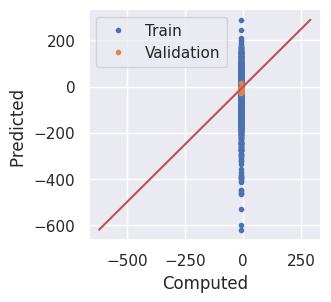

Epoch: 1, Train MAE: 20.7203, Val MAE: 1.9769
Epoch: 2, Train MAE: 2.5895, Val MAE: 2.0805
Epoch: 3, Train MAE: 1.5810, Val MAE: 1.6202
Epoch: 4, Train MAE: 1.1720, Val MAE: 1.2905
Epoch: 5, Train MAE: 0.9482, Val MAE: 1.2035


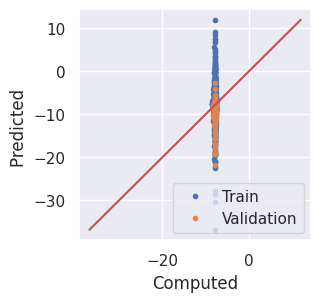

Epoch: 6, Train MAE: 0.8235, Val MAE: 1.0289
Epoch: 7, Train MAE: 0.6938, Val MAE: 1.1439
Epoch: 8, Train MAE: 0.6172, Val MAE: 1.2157
Epoch: 9, Train MAE: 0.5203, Val MAE: 1.3178
Epoch: 10, Train MAE: 0.4898, Val MAE: 1.4418


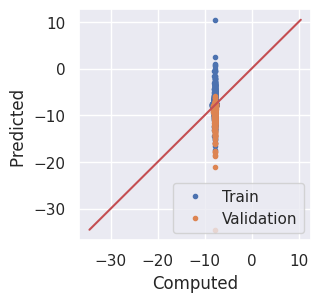

Epoch: 11, Train MAE: 0.4351, Val MAE: 1.6181
Epoch: 12, Train MAE: 0.3785, Val MAE: 2.0760
Epoch: 13, Train MAE: 0.3391, Val MAE: 2.7753
Epoch: 14, Train MAE: 0.3128, Val MAE: 2.9691
Epoch: 15, Train MAE: 0.3029, Val MAE: 3.4181


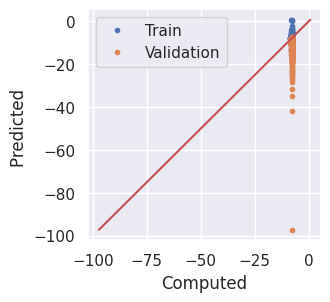

Epoch: 16, Train MAE: 0.2819, Val MAE: 3.9442
Epoch: 17, Train MAE: 0.3178, Val MAE: 3.7278
Epoch: 18, Train MAE: 0.2146, Val MAE: 4.0623
Epoch: 19, Train MAE: 0.2233, Val MAE: 3.5771
Epoch: 20, Train MAE: 0.2725, Val MAE: 2.8140


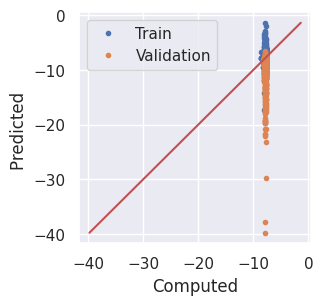

Epoch: 21, Train MAE: 0.3177, Val MAE: 2.2285
Epoch: 22, Train MAE: 0.1318, Val MAE: 1.7946
Epoch: 23, Train MAE: 0.1363, Val MAE: 1.7925
Epoch: 24, Train MAE: 0.1276, Val MAE: 1.5306
Epoch: 25, Train MAE: 0.1366, Val MAE: 1.1411


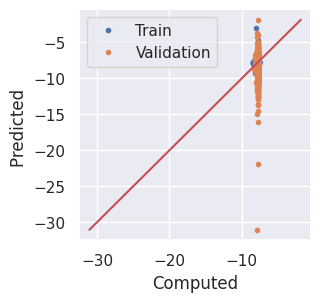

Epoch: 26, Train MAE: 0.1262, Val MAE: 1.0602
Epoch: 27, Train MAE: 0.1116, Val MAE: 1.0593
Epoch: 28, Train MAE: 0.0981, Val MAE: 1.2102
Epoch: 29, Train MAE: 0.1137, Val MAE: 1.5696
Epoch: 30, Train MAE: 0.0997, Val MAE: 1.0787


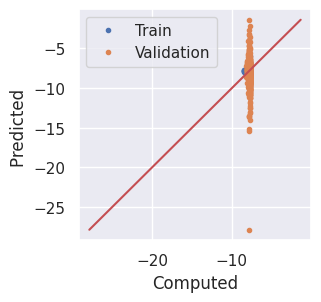

Epoch: 31, Train MAE: 0.0853, Val MAE: 0.9753
Epoch: 32, Train MAE: 0.0879, Val MAE: 0.9274
Epoch: 33, Train MAE: 0.0757, Val MAE: 1.0724
Epoch: 34, Train MAE: 0.0709, Val MAE: 1.1390
Epoch: 35, Train MAE: 0.0704, Val MAE: 1.0735


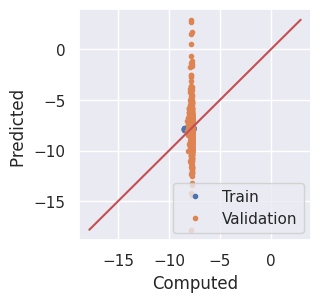

Epoch: 36, Train MAE: 0.0680, Val MAE: 1.1345
Epoch: 37, Train MAE: 0.0701, Val MAE: 1.1117
Epoch: 38, Train MAE: 0.0672, Val MAE: 1.0828
Epoch: 39, Train MAE: 0.0618, Val MAE: 1.0879
Epoch: 40, Train MAE: 0.0612, Val MAE: 1.0887


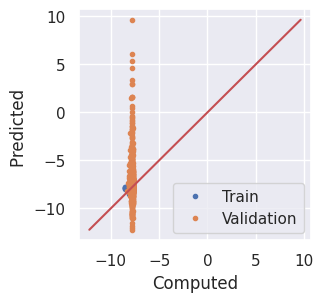

Epoch: 41, Train MAE: 0.0617, Val MAE: 1.4033
Epoch: 42, Train MAE: 0.0620, Val MAE: 1.1843
Epoch: 43, Train MAE: 0.0591, Val MAE: 1.0344
Epoch: 44, Train MAE: 0.0586, Val MAE: 1.0669
Epoch: 45, Train MAE: 0.0575, Val MAE: 1.1042


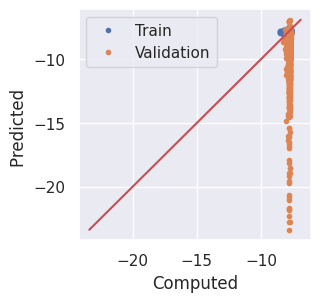

Epoch: 46, Train MAE: 0.0598, Val MAE: 2.0424
Epoch: 47, Train MAE: 0.0575, Val MAE: 2.3457
Epoch: 48, Train MAE: 0.0568, Val MAE: 1.6659
Epoch: 49, Train MAE: 0.0564, Val MAE: 1.6956
Epoch: 50, Train MAE: 0.0569, Val MAE: 1.8354


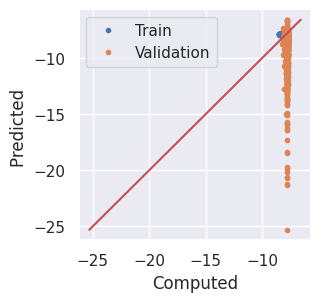

Epoch: 51, Train MAE: 0.0568, Val MAE: 1.7501
Epoch: 52, Train MAE: 0.0561, Val MAE: 1.7312
Epoch: 53, Train MAE: 0.0560, Val MAE: 1.7503
Epoch: 54, Train MAE: 0.0560, Val MAE: 1.8958
Epoch: 55, Train MAE: 0.0559, Val MAE: 1.8762


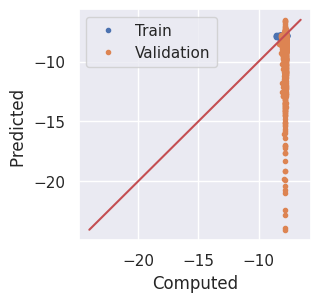

Epoch: 56, Train MAE: 0.0552, Val MAE: 2.0285
Epoch: 57, Train MAE: 0.0557, Val MAE: 1.7978
Epoch: 58, Train MAE: 0.0555, Val MAE: 1.6905
Epoch: 59, Train MAE: 0.0553, Val MAE: 1.9402
Epoch: 60, Train MAE: 0.0552, Val MAE: 1.6523


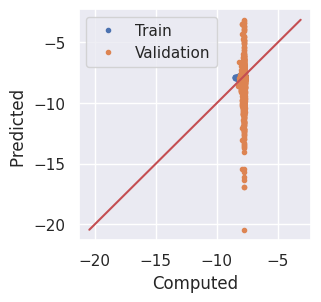

Epoch: 61, Train MAE: 0.0553, Val MAE: 1.3158
Epoch: 62, Train MAE: 0.0556, Val MAE: 1.4673
Epoch: 63, Train MAE: 0.0554, Val MAE: 1.6517
Epoch: 64, Train MAE: 0.0547, Val MAE: 1.7720
Epoch: 65, Train MAE: 0.0546, Val MAE: 1.8626


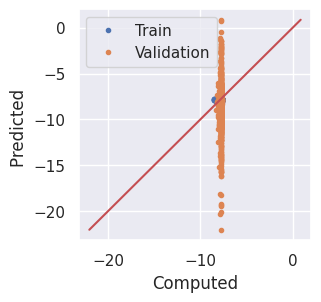

Epoch: 66, Train MAE: 0.0546, Val MAE: 1.7635
Epoch: 67, Train MAE: 0.0548, Val MAE: 1.8091
Epoch: 68, Train MAE: 0.0547, Val MAE: 1.7289
Epoch: 69, Train MAE: 0.0545, Val MAE: 1.6775
Epoch: 70, Train MAE: 0.0548, Val MAE: 1.6895


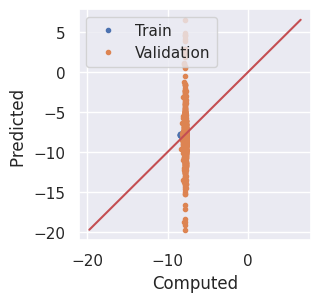

Epoch: 71, Train MAE: 0.0546, Val MAE: 1.9209
Epoch: 72, Train MAE: 0.0546, Val MAE: 2.2120
Epoch: 73, Train MAE: 0.0548, Val MAE: 2.2179
Epoch: 74, Train MAE: 0.0547, Val MAE: 1.8494
Epoch: 75, Train MAE: 0.0545, Val MAE: 2.2122


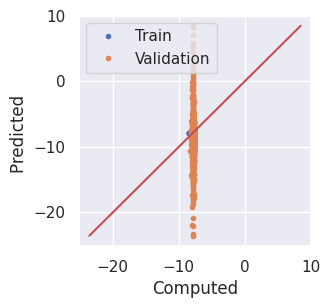

Epoch: 76, Train MAE: 0.0545, Val MAE: 2.5768
Epoch: 77, Train MAE: 0.0547, Val MAE: 2.7755
Epoch: 78, Train MAE: 0.0545, Val MAE: 2.6596
Epoch: 79, Train MAE: 0.0554, Val MAE: 2.7496
Epoch: 80, Train MAE: 0.0546, Val MAE: 2.5074


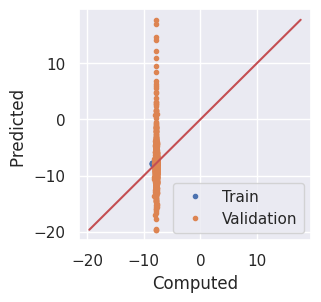

Epoch: 81, Train MAE: 0.0548, Val MAE: 2.5618
Epoch: 82, Train MAE: 0.0548, Val MAE: 3.6660
Epoch: 83, Train MAE: 0.0546, Val MAE: 3.1225
Epoch: 84, Train MAE: 0.0546, Val MAE: 2.5795
Epoch: 85, Train MAE: 0.0546, Val MAE: 2.9234


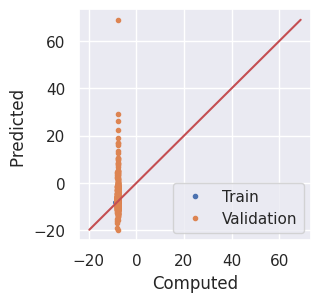

Epoch: 86, Train MAE: 0.0548, Val MAE: 3.4123
Epoch: 87, Train MAE: 0.0551, Val MAE: 4.5980
Epoch: 88, Train MAE: 0.0546, Val MAE: 5.2698
Epoch: 89, Train MAE: 0.0545, Val MAE: 3.9479
Epoch: 90, Train MAE: 0.0546, Val MAE: 4.3436


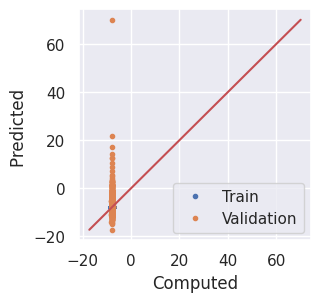

Epoch: 91, Train MAE: 0.0547, Val MAE: 3.0160
Epoch: 92, Train MAE: 0.0546, Val MAE: 2.1306
Epoch: 93, Train MAE: 0.0546, Val MAE: 1.8553
Epoch: 94, Train MAE: 0.0545, Val MAE: 2.0260
Epoch: 95, Train MAE: 0.0550, Val MAE: 2.2586


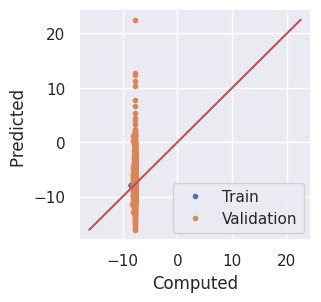

Epoch: 96, Train MAE: 0.0548, Val MAE: 2.5292
Epoch: 97, Train MAE: 0.0565, Val MAE: 2.5177
Epoch: 98, Train MAE: 0.0551, Val MAE: 3.4749
Epoch: 99, Train MAE: 0.0547, Val MAE: 2.7964
Epoch: 100, Train MAE: 0.0546, Val MAE: 4.5395


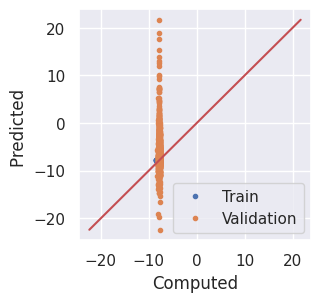

Epoch: 101, Train MAE: 0.0545, Val MAE: 3.2417
Epoch: 102, Train MAE: 0.0548, Val MAE: 2.4649
Epoch: 103, Train MAE: 0.0547, Val MAE: 4.3421
Epoch: 104, Train MAE: 0.0547, Val MAE: 4.1907
Epoch: 105, Train MAE: 0.0546, Val MAE: 4.5687


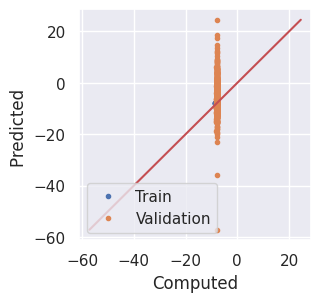

Epoch: 106, Train MAE: 0.0547, Val MAE: 4.0226
Epoch: 107, Train MAE: 0.0545, Val MAE: 4.2541
Epoch: 108, Train MAE: 0.0546, Val MAE: 4.2258
Epoch: 109, Train MAE: 0.0546, Val MAE: 4.2450


In [ ]:
# Train the model
train_losses = []
val_losses   = []
for epoch in np.arange(0, n_epochs):
    train_loss, train_predictions, train_ground_truths = clm.train(model, criterion, train_loader,
                                                                   target_factor.to(device),
                                                                   standardized_parameters['target_mean'].to(device),
                                                                   optimizer)
    val_loss,   val_predictions,   val_ground_truths   =  clm.test(model, criterion, val_loader,
                                                                   target_factor.to(device),
                                                                   standardized_parameters['target_mean'].to(device))

    # Pass to energy units (same as initial Fv)
    train_loss = np.sqrt(train_loss) * target_factor.item()
    val_loss   = np.sqrt(val_loss)   * target_factor.item()

    if epoch%5 == 0:
        stack = np.concatenate([train_predictions, train_ground_truths,
                                val_predictions,   val_ground_truths])
    
        _min_ = np.min(stack)
        _max_ = np.max(stack)
    
        plt.figure(figsize=(3, 3))
        plt.plot(train_ground_truths, train_predictions, '.', label='Train')
        plt.plot(val_ground_truths,   val_predictions,   '.', label='Validation')
        plt.xlabel(r'Computed')
        plt.ylabel(r'Predicted ')
        plt.plot([_min_, _max_], [_min_, _max_], '-r')
        plt.legend(loc='best')
        plt.show()
    
    # Append losses
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Check early stopping criteria
    early_stopping(val_loss, model)

    if early_stopping.early_stop:
        print('Early stopping')
        break

    print(f'Epoch: {epoch+1}, Train MAE: {train_loss:.4f}, Val MAE: {val_loss:.4f}')

In [ ]:
plt.plot(np.log10(train_losses), label='Train loss')
plt.plot(np.log10(val_losses) , label='Val  loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

# Check test data

In [ ]:
# Load Graph Neural Network model
model = clm.GCNN(features_channels=n_node_features, pdropout=dropout)

# Moving model to device
model = model.to(device)

# Load Graph Neural Network model
model.load_state_dict(torch.load(files_names['model_name'], map_location=torch.device(device)))
model.eval()  # Evaluation mode, drops out dropouts

In [ ]:
train_loss, train_predictions, train_ground_truths = clm.test(model, criterion, train_loader,
                                                              target_factor.to(device),
                                                              standardized_parameters['target_mean'].to(device))
val_loss,   val_predictions,   val_ground_truths   =  clm.test(model, criterion, val_loader,
                                                               target_factor.to(device),
                                                               standardized_parameters['target_mean'].to(device))
test_loss,  test_predictions,  test_ground_truths  =  clm.test(model, criterion, test_loader,
                                                               target_factor.to(device),
                                                               standardized_parameters['target_mean'].to(device))

# Pass to energy units (same as initial Fv)
train_loss = np.sqrt(train_loss) * target_factor.item()
val_loss   = np.sqrt(val_loss)   * target_factor.item()
test_loss  = np.sqrt(test_loss)  * target_factor.item()

stack = np.concatenate([train_predictions, train_ground_truths,
                        val_predictions,   val_ground_truths,
                        test_predictions,  test_ground_truths])

_min_ = np.min(stack)
_max_ = np.max(stack)

plt.figure(figsize=(5, 5))
plt.xlabel(r'Computed $E_0$ (eV/atom)')
plt.ylabel(r'Predicted $E_0$ (eV/atom)')
plt.plot(train_ground_truths, train_predictions, '.', label='Train')
plt.plot(val_ground_truths,   val_predictions,   '.', label='Validation')
plt.plot(test_ground_truths,  test_predictions,  '.', label='Test')
plt.plot([_min_, _max_], [_min_, _max_], '-r')
plt.legend(loc='best')
plt.savefig(f'{target_folder}/{target}-GCNN-training.pdf', dpi=dpi, bbox_inches='tight')
plt.show()

print(f'Train MAE: {train_loss:.4f}, Val MAE: {val_loss:.4f}, Test MAE: {test_loss:.4f}')

In [ ]:
dataset = [data for dataset in [train_dataset, val_dataset] for data in dataset]

loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

loss, predictions, ground_truths = clm.test(model, criterion, loader,
                                            target_factor.to(device),
                                            standardized_parameters['target_mean'].to(device))

uncertainties = ground_truths - predictions
uncertainties

In [ ]:
# Generate dictionary with uncertainty data
# label: uncertainty = ground-truth - prediction
uncertainty_data = {}
for idx in range(dataset):
    uncertainty_data.update(
        {dataset[idx].label: float(uncertainties[idx])}
    )

# Dump the dictionary with numpy arrays to a JSON file
with open(files_names['uncert_data_name'], 'w') as json_file:
    json.dump(uncertainty_data, json_file)